- BatchNormalization
- Resnet, Senet
- Hyperparameter Tuning
- preprocess
- check unfreezed layers in different architectures

In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.keras.__version__)
print(tf.__version__)
tf.config.list_physical_devices('GPU')
#keras.mixed_precision.set_global_policy("mixed_float16") # turn on mixed precision for faster computation

2.12.0
2.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="vgg16", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-4]:
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)

model.summary()
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vggface_resnet50 (Functiona  (None, 1, 1, 2048)       23561152  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544

In [4]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'
#train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/train_set'
#test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/val_set'

In [5]:
import random

def load_data(train_img_dir, test_img_dir):

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=0.2,
        subset='both'
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=None
    )

    return train_dataset, test_dataset

In [6]:
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.


In [7]:
from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10)
]

print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Saving model as: 20230711_11-05_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 385s 53ms/step - loss: 1.6053 - accuracy: 0.5220 - val_loss: 1.0945 - val_accuracy: 0.6347
Epoch 2/50
7192/7192 [==============================] - 380s 53ms/step - loss: 1.1663 - accuracy: 0.6158 - val_loss: 1.0052 - val_accuracy: 0.6644
Epoch 3/50
7192/7192 [==============================] - 382s 53ms/step - loss: 1.0792 - accuracy: 0.6424 - val_loss: 0.9635 - val_accuracy: 0.6784
Epoch 4/50
7192/7192 [==============================] - 385s 54ms/step - loss: 1.0318 - accuracy: 0.6576 - val_loss: 0.9391 - val_accuracy: 0.6869
Epoch 5/50
7192/7192 [==============================] - 382s 53ms/step - loss: 0.9976 - accuracy: 0.6693 - val_loss: 0.9241 - val_accuracy: 0.6928
Epoch 6/50
7192/7192 [==============================] - 383s 53ms/step - loss: 0.9769 - accuracy: 0.6772 - val_loss: 0.9123 - val_accuracy: 0.6967
Epoch 7/50
7192/7192 [==============================] - 4

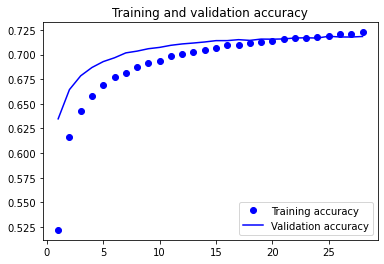

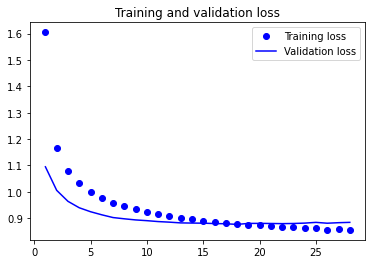

In [8]:
# complete dataset
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

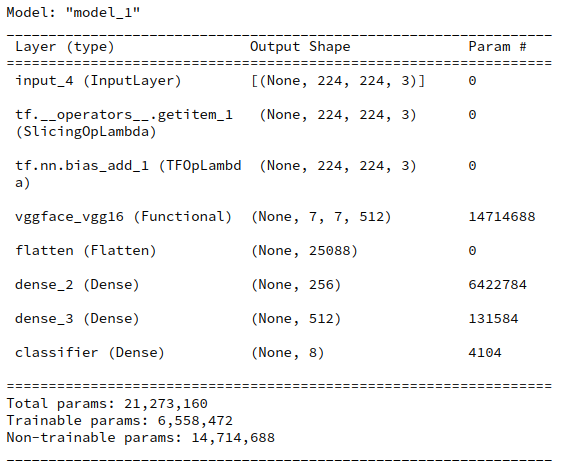

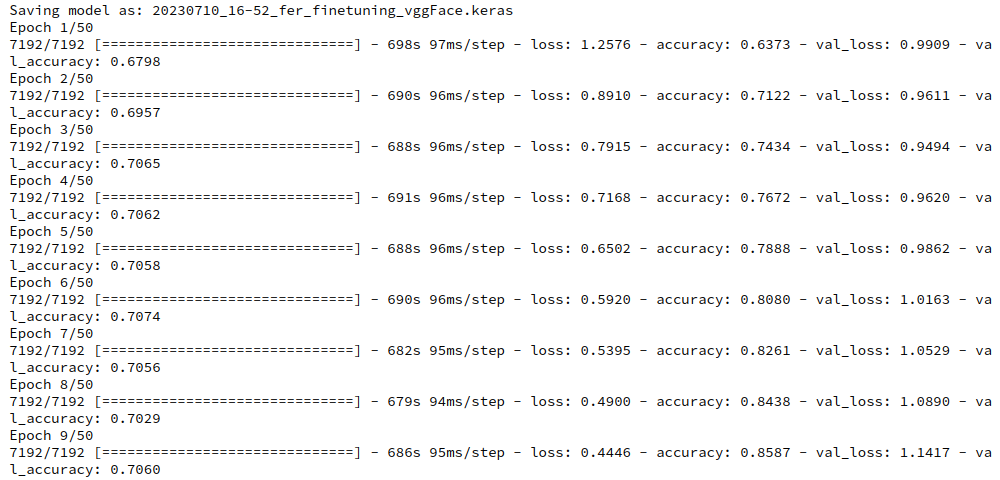

In [16]:
# complete dataset
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230710_16-52_fer_finetuning_vggFace.keras
125/125 [==============================] - 10s 76ms/step - loss: 2.4296 - accuracy: 0.3993
Test accuracy: 0.399


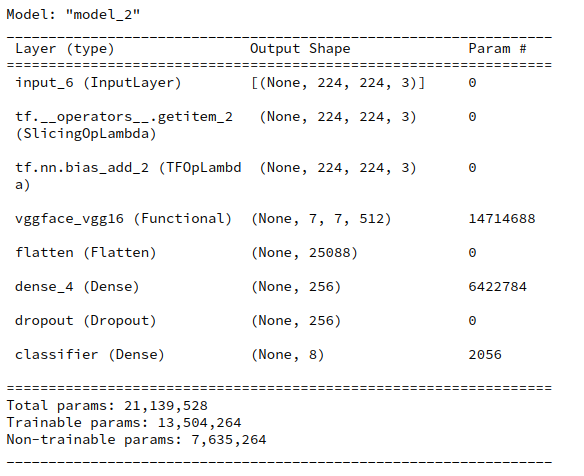

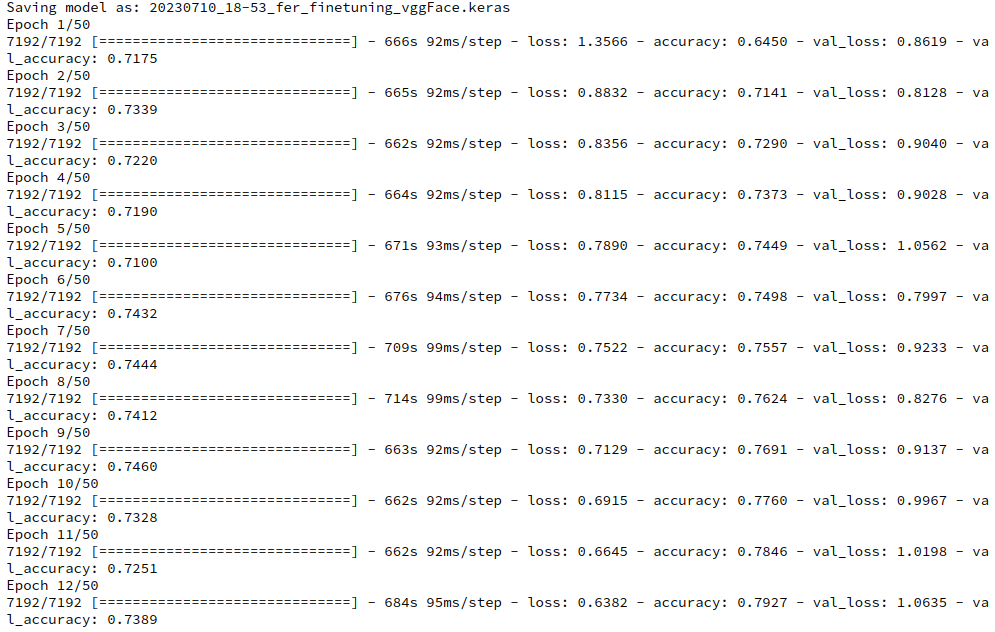

In [20]:
# complete dataset
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230710_18-53_fer_finetuning_vggFace.keras
125/125 [==============================] - 10s 82ms/step - loss: 2.1219 - accuracy: 0.4119
Test accuracy: 0.412
